# Regression Trees and Model Optimization - Lab

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate the performance of decision tree models

## Boston Housing dataset - again! 

The dataset is available in the file `'boston.csv'`. 

- Import the dataset and print its `.head()` and dimensions: 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML, Markdown
plt.style.use('ggplot')
%matplotlib inline

# Load the Boston housing dataset 
data = pd.read_csv('boston.csv') 

# Print the first five rows 
display(HTML(data.head().to_html()))

# Print the dimensions of data
data.shape

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


(506, 15)

## Identify features and target data 

In this lab, we will use three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`: 

#### Features
- `'RM'` is the average number of rooms among homes in the neighborhood 
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor) 
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood 

#### Target
- `MEDV`',the median value of the home 

- Create DataFrames for the features and the target variable as shown above 
- Inspect the contents for validity 

In [2]:
# Features and target data
target = data[['medv']]
display(HTML(target.head().to_html()))

features = data[['rm', 'lstat', 'ptratio']]
display(HTML(features.head().to_html()))

,medv
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


,rm,lstat,ptratio
0,6.575,4.98,15.3
1,6.421,9.14,17.8
2,7.185,4.03,17.8
3,6.998,2.94,18.7
4,7.147,5.33,18.7


## Inspect correlations 

- Use scatter plots to show the correlation between the chosen features and the target variable
- Comment on each scatter plot 

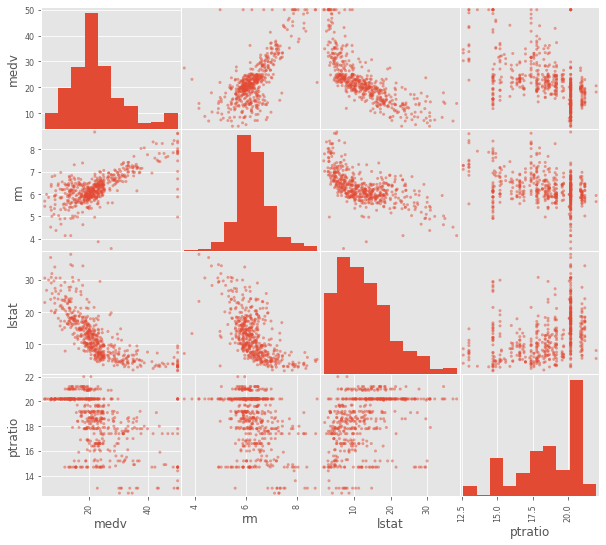

In [3]:
# Your code here 
from pandas.plotting import scatter_matrix
scatter_matrix(pd.concat([target, features], axis=1), figsize=(10,9))
plt.show()

In [4]:
# there appears to be a positive linear relationship between medv ~ rm
# there appears to be a negative quadratic relationship between medv ~ lstat (but it may be acceptable to treat as a negative linear relationship)
# linear relationships between medv and other predictors is not apparent

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return the r-squared score and MSE for two equal-sized arrays for the given true and predicted values 

In [5]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)
    
    # Calculate the mean squared error between 'y_true' and 'y_predict'
    mse = mean_squared_error(y_true, y_predict)
    
    # Return the score
    return (r2, mse)


# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.4719999999999998]

(0.9228556485355649, 0.4719999999999998)

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [6]:
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [7]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
regressor = DecisionTreeRegressor(random_state=45)
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

# [0.47097115950374013, 38.795686274509805]  - R2, MSE

(0.47097115950374013, 38.795686274509805)

## Hyperparameter tuning (I)

- Find the best tree depth using depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate MSE and r-squared for each run 
- Plot both performance measures for all runs 
- Comment on the output 

In [8]:
# Your code here
SEED = 45

def optimize_decision_tree_regressor(X_train, y_train, X_test, y_test, hp):

    r2_mse_test = []

    best_r2_mse_test = None

    print(f"finding optimal {hp[0]} hyper-parameter value from {hp[1]}...")

    for hp_val in hp[1]:
        if hp[0] == 'max_depth':
            dtr = DecisionTreeRegressor(max_depth=hp_val, random_state=SEED)
        elif hp[0] == 'min_samples_split':
            dtr = DecisionTreeRegressor(min_samples_split=hp_val, random_state=SEED)
        else:
            print(f"hyper-parameter '{hp[0]}' is not supported!")
            return

        dtr.fit(X_train, y_train)

        # test
        y_hat_test = dtr.predict(X_test) 
        score_test = performance(y_test, y_hat_test)
        r2_mse_test.append(score_test)

        if best_r2_mse_test is None or (score_test[0] > best_r2_mse_test[1][0] and score_test[1] < best_r2_mse_test[1][1]):
            best_r2_mse_test = (hp_val, score_test)

    # r2 first
    fig = plt.figure(figsize=(12,10))
    plt.plot(hp[1], list(map(lambda t: t[0], r2_mse_test)), label='Test $R^2$')
    s_optimal_hp_val = f"optimal {hp[0]}: {best_r2_mse_test[0]}, test $R^2$: {best_r2_mse_test[1][0]}"
    plt.axvline(best_r2_mse_test[0], linestyle='--', c='black', label=s_optimal_hp_val)
    plt.ylabel('$R^2$')
    plt.xlabel(f"{hp[0]}")
    plt.legend()
    plt.title(f"$R^2$ vs {hp[0]}")
    fig.tight_layout()
    plt.show()
    print(s_optimal_hp_val)

    # mse
    fig = plt.figure(figsize=(12,10))
    plt.plot(hp[1], list(map(lambda t: t[1], r2_mse_test)), label='Test MSE')
    s_optimal_hp_val = f"optimal {hp[0]}: {best_r2_mse_test[0]}, test MSE: {best_r2_mse_test[1][1]}"
    plt.axvline(best_r2_mse_test[0], linestyle='--', c='black', label=s_optimal_hp_val)
    plt.ylabel('MSE')
    plt.xlabel(f"{hp[0]}")
    plt.legend()
    plt.title(f"MSE vs {hp[0]}")
    fig.tight_layout()
    plt.show()
    print(s_optimal_hp_val)

    return best_r2_mse_test

finding optimal max_depth hyper-parameter value from [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]...


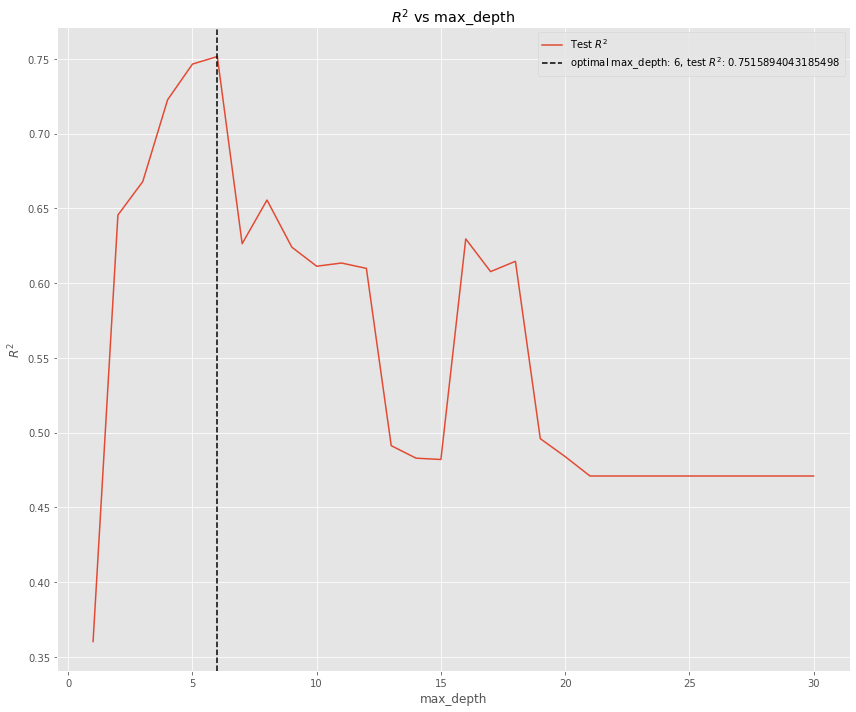

optimal max_depth: 6, test $R^2$: 0.7515894043185498


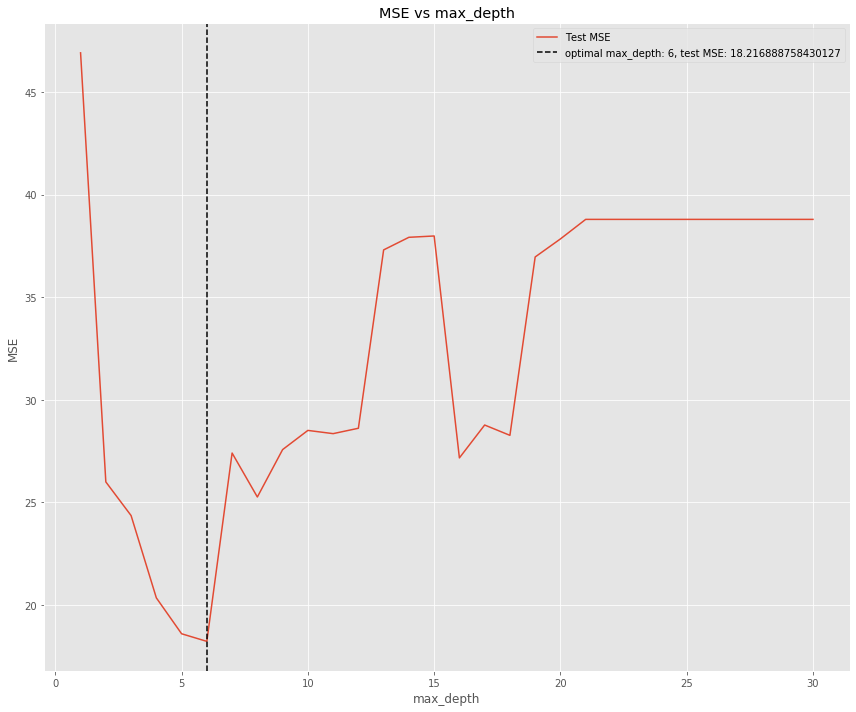

optimal max_depth: 6, test MSE: 18.216888758430127


In [9]:
max_depths = np.array(list(range(1,31)))
best_r2_mse_test = optimize_decision_tree_regressor(X_train, y_train, X_test, y_test, ('max_depth', max_depths))
optimal_max_depth = best_r2_mse_test[0]

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

finding optimal min_samples_split hyper-parameter value from [ 2  3  4  5  6  7  8  9 10]...


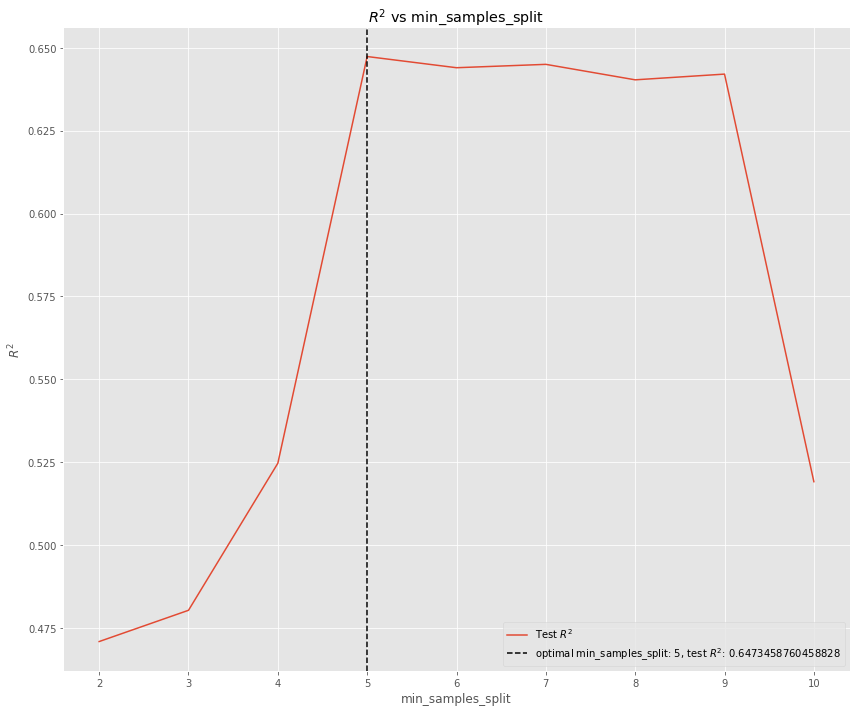

optimal min_samples_split: 5, test $R^2$: 0.6473458760458828


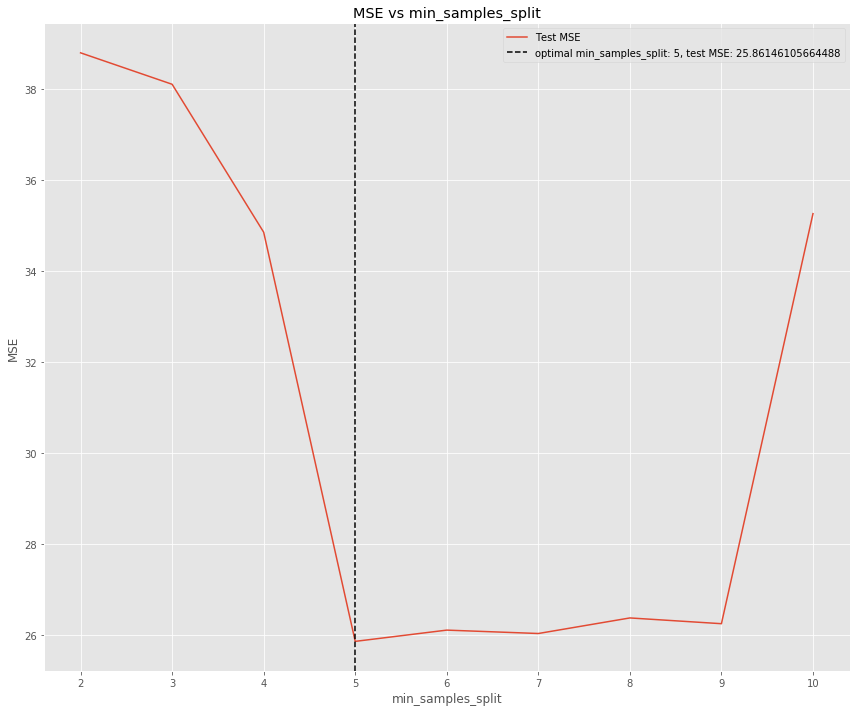

optimal min_samples_split: 5, test MSE: 25.86146105664488


In [10]:
# Your code here 
min_samples_splits = np.array(list(range(2,11)))
best_r2_mse_test = optimize_decision_tree_regressor(X_train, y_train, X_test, y_test, ('min_samples_split', min_samples_splits))
optimal_min_samples_split = best_r2_mse_test[0]

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [11]:
# Your code here 
dtr = DecisionTreeRegressor(
    max_depth=optimal_max_depth, 
    min_samples_split=optimal_min_samples_split,
    random_state=SEED
)
print(dtr)
dtr.fit(X_train, y_train)

y_hat_test = dtr.predict(X_test)
score = performance(y_test, y_hat_test)
score

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=45, splitter='best')


(0.7515894043185498, 18.216888758430127)

## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like max-features to find a more optimal version of the model 

## Summary 

In this lab, we looked at applying a decision-tree-based regression analysis on the Boston Housing dataset. We saw how to train various models to find the optimal values for hyperparameters. 